In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction_for_coupled_momentum_interatcion_model

from project_ssms.coupled_momentum_interaction_observation2 import CoupledMomentumInteractionObservation, CoupledMomentumInteractionTransformation
from project_ssms.momentum_utils import filter_traj_by_speed

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# data

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

session_data = datasets_processed[0].render_trajectories([3,8])
traj0 = np.concatenate((session_data), axis=1)

In [4]:
del datasets_processed
del session_data

In [5]:
f_traj = filter_traj_by_speed(traj0, q1=0.99, q2=0.99)

In [6]:
arena_xmin = 10
arena_xmax = 320

arena_ymin = -10
arena_ymax = 390

WATER = torch.tensor([50, 50], dtype=torch.float64)
FOOD = torch.tensor([270, 50], dtype=torch.float64)
NEST = torch.tensor([270, 330], dtype=torch.float64)
CORNER = torch.tensor([50, 330], dtype=torch.float64)

# model

$$ x^a_t \sim x^a_{t-1} +  c_m * \sigma(\alpha^a_k) m^a_t + c_i * 
\sigma(\beta^a_k) i^a_t + v_{max} \sigma(W_k x^{a,b} + b_k))  \qquad | \qquad z_t =k$$ 

where

- $a$, $b$ are the indices of the mouse.
- $m^a_t$ is the momentum vector, obtained by applying a (weighted) linear regression to the past #lags observations, and scaling the fitted vector by 1/#lags.
- $v_{max}$ = 5
- $c_m = c_i = 2$

the trainable parameters are:

- $\alpha$: to what extent the momentum influences the next observation
- $\beta$: to what extent the direction to the other animal influences the next observation
- $W$ and $b$ are regression parameters of the previous observation


In [7]:
momentum_lags = 30
momentum_weights = np.arange(0.55, 2.05, 0.05)

In [9]:
data = torch.tensor(f_traj, dtype=torch.float64)

In [8]:
torch.manual_seed(0)
np.random.seed(0)

bounds = np.array([[arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5], 
                   [arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5]])

max_v = np.array([5.0, 5.0, 5.0, 5.0])

m_factor = 2
i_factor = 2

K = 4
D = 4
Df = 10
T = 36000

observation = CoupledMomentumInteractionObservation(K=K, D=D, M=0, bounds=bounds,
                                         momentum_lags=momentum_lags,momentum_weights=momentum_weights,
                                         max_v=max_v, m_factor=m_factor, i_factor=i_factor)

model = HMM(K=K, D=D, M=0, observation=observation)
m_tran = model.observation.transformation

model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [47]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [10]:
momentum_vecs = CoupledMomentumInteractionTransformation._compute_momentum_vecs(data[:-1], lags=momentum_lags)
interaction_vecs = CoupledMomentumInteractionTransformation._compute_direction_vecs(data[:-1])

In [11]:
model.log_likelihood(data, momentum_vecs=momentum_vecs, interaction_vecs=interaction_vecs)

tensor(-2290594.7152, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [12]:
num_iters = 5000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.001, momentum_vecs=momentum_vecs, interaction_vecs=interaction_vecs)

iter 4990 loss 441609.92: 100%|██████████| 5000/5000 [34:56<00:00,  2.40it/s]  | 0/5000 [00:00<?, ?it/s]


In [21]:
num_iters = 3000
losses_1, opt_1 = model.fit(data, num_iters=num_iters, lr=0.0005, momentum_vecs=momentum_vecs, interaction_vecs=interaction_vecs)

iter 2990 loss 433915.65: 100%|██████████| 3000/3000 [21:38<00:00,  2.42it/s] | 0/3000 [00:00<?, ?it/s]


In [28]:
num_iters = 3000
losses_2, _ = model.fit(data, optimizer=opt_1, num_iters=num_iters, momentum_vecs=momentum_vecs, interaction_vecs=interaction_vecs)

iter 2990 loss 426316.77: 100%|██████████| 3000/3000 [21:05<00:00,  1.79it/s] | 0/3000 [00:00<?, ?it/s]


In [ ]:
num_iters = 1000
losses_3, opt_2 = model.fit(data, num_iters=num_iters, lr=0.001, momentum_vecs=momentum_vecs, interaction_vecs=interaction_vecs)

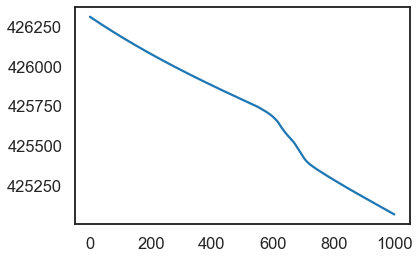

In [49]:
plt.plot(losses_3[0:])

In [50]:
z = model.most_likely_states(data)

In [51]:
x_predict = k_step_prediction_for_coupled_momentum_interatcion_model(model, z, data,
                                                         momentum_vecs=momentum_vecs, interaction_vecs=interaction_vecs)

([], <a list of 0 Text yticklabel objects>)

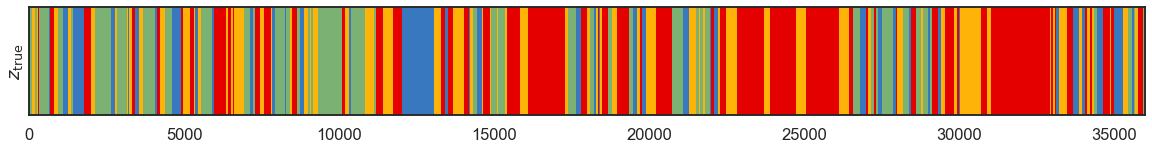

In [52]:
plt.figure(figsize=(20,2))
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

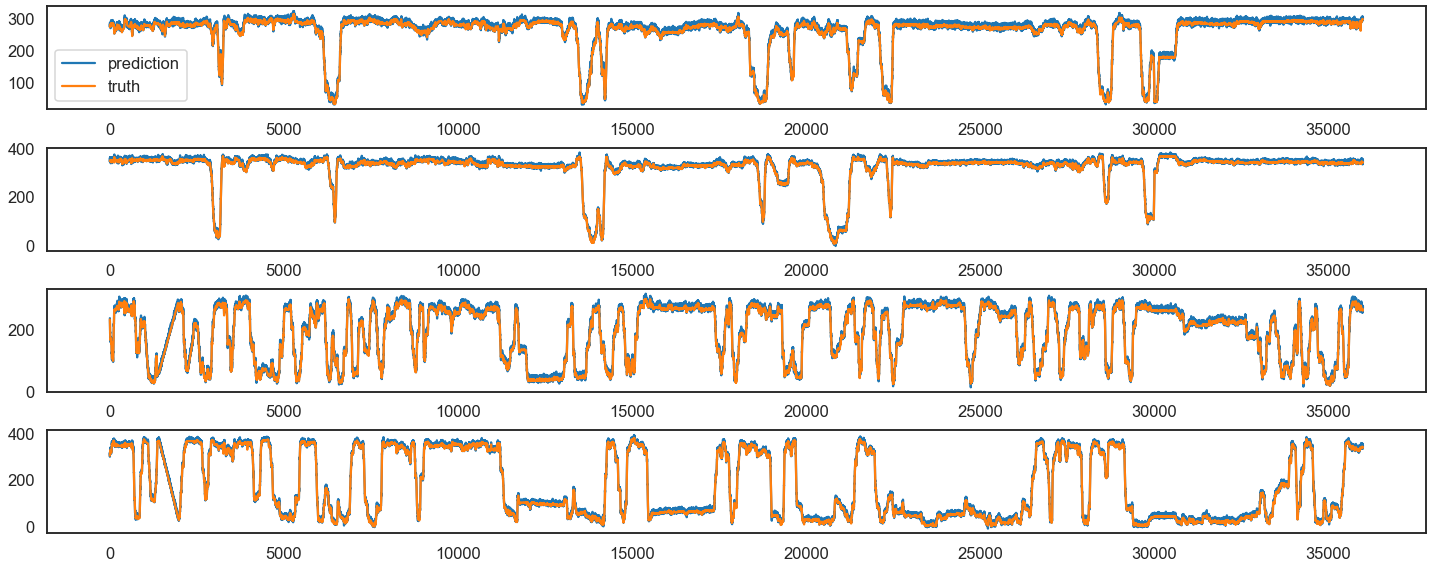

In [53]:
plt.figure(figsize=(20,8))

plt.subplot(4,1,1)
plt.plot(x_predict[:,0], label='prediction')
plt.plot(data[:,0].numpy(), label='truth')
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_predict[:,1], label='prediction')
plt.plot(data[:,1].numpy(), label='truth')

plt.subplot(4,1,3)
plt.plot(x_predict[:,2], label='prediction')
plt.plot(data[:,2].numpy(), label='truth')

plt.subplot(4,1,4)
plt.plot(x_predict[:,3], label='prediction')
plt.plot(data[:,3].numpy(), label='truth')

plt.tight_layout()

In [54]:
torch.sigmoid(m_tran.alpha)

tensor([[0.9981, 0.1522, 0.3045, 0.9937],
        [0.9917, 0.9954, 0.9882, 0.9865],
        [0.0226, 0.0293, 0.0158, 0.0208],
        [0.9888, 0.3439, 0.8430, 0.2542]], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)

In [55]:
torch.sigmoid(m_tran.beta)

tensor([[0.9957, 0.9957, 0.0162, 0.0085],
        [0.9857, 0.9959, 0.0162, 0.0122],
        [0.9854, 0.9924, 0.0189, 0.0181],
        [0.9955, 0.1770, 0.0139, 0.8634]], dtype=torch.float64,
       grad_fn=<SigmoidBackward>)

In [56]:
[sum(z == k) for k in range(K)]

[5608, 13185, 8767, 8440]

# samples

In [66]:
model.observation.mus_init =torch.tensor([320, 320, 320, 320], dtype=torch.float64)

In [67]:
sample_z, sample_x = model.sample(T)

([], <a list of 0 Text yticklabel objects>)

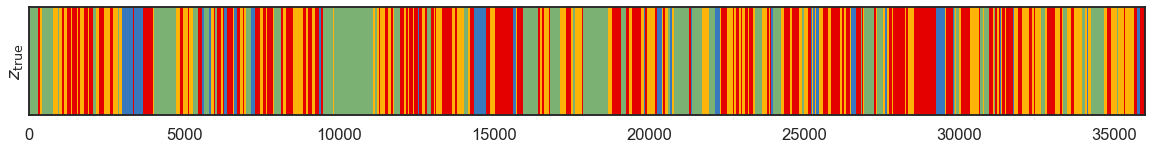

In [59]:
plt.figure(figsize=(20,2))
plt.imshow(sample_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

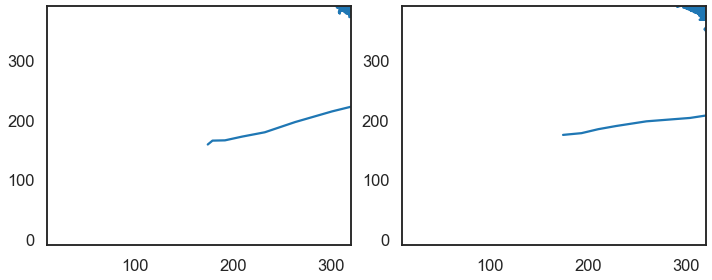

In [65]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(sample_x[:,0], sample_x[:,1])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
plt.subplot(1,2,2)
plt.plot(sample_x[:,2], sample_x[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)

plt.tight_layout()

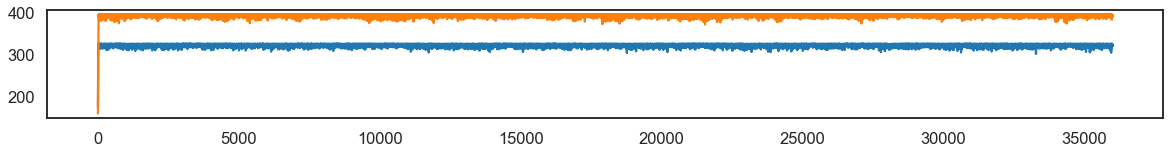

In [64]:
plt.figure(figsize=(20,2))

plt.plot(sample_x[:,0])
plt.plot(sample_x[:,1])